In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from tifffile import imread
import napari

In [2]:
core = '102'

In [3]:
save_dir = (
    '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/' +
    'ghost_artifact'
    )
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# read unfiltered single-cell data
data = pd.read_parquet(
    '/Volumes/My Book/cylinter_input/emit22_full/output/' +
    'checkpoints/getSingleCellData.parquet'
    )

# crop coordinates
# whole image
ymin = 0
ymax = 2943
xmin = 0
xmax = 2943

# cropped image
# ymin = 1700
# ymax = 1890
# xmin = 1925
# xmax = 2125

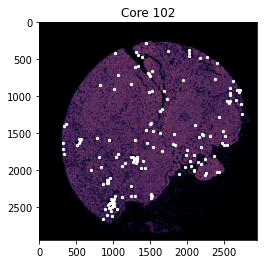

In [4]:
# read DNA1 image of selected tissue and crop to target size
dna = imread(
    f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=0
    )
dna_crop = dna[ymin:ymax, xmin:xmax]

# read segmentation outlines for selected tissue and crop to target size
seg = imread(
    f'/Volumes/My Book/cylinter_input/emit22_full/seg/{core}.ome.tif', key=0
    )
seg_crop = seg[ymin:ymax, xmin:xmax]

# isolate data for cells within ROI bounds (original coordinates)
dna_intensity_threshold = (0, 9000)
data_roi = data[['Y_centroid', 'X_centroid', 'DNA1_cellMask']][
    (data['Sample'] == core) &
    (data['X_centroid'].between(xmin, xmax, inclusive=True)) &
    (data['Y_centroid'].between(ymin, ymax, inclusive=True)) &
    (data['DNA1_cellMask'].between(dna_intensity_threshold[0],
                                   dna_intensity_threshold[1],
                                   inclusive=True))
    ]

# transform x, y coordinates of cells within ROI bounds
data_roi['X_centroid'] = data_roi['X_centroid']-xmin
data_roi['Y_centroid'] = data_roi['Y_centroid']-ymin

# plot channel images and segmentation outlines
plt.imshow(dna_crop * 2.0, cmap='magma')
plt.imshow(seg_crop, alpha=0.5, cmap='Greys_r')
plt.grid(False)

# overlay cell centorids
plt.scatter(
    data_roi['X_centroid'],
    data_roi['Y_centroid'], s=5.0, color='w'
    )
plt.title(f'Core {core}')
plt.savefig(
    os.path.join(
        save_dir,
        'ghost_artifact.pdf')
        )
plt.show()
plt.close('all')

In [5]:
# read segmentation outlines
seg = imread(
    f'/Volumes/My Book/cylinter_input/emit22_full/seg/{core}.ome.tif',
    key=0
    )
seg_crop = seg[ymin:ymax, xmin:xmax]

centroids = data[['Y_centroid', 'X_centroid']][data.index.isin(data_roi.index)]
viewer = napari.view_image(
    dna, rgb=False, name='DNA1'
    )

viewer.add_image(
    seg, rgb=False, blending='additive',
    opacity=0.5, colormap='green', visible=False,
    name='segmentation'
    )

viewer.add_points(
    centroids, name='ghosts',
    face_color='white',
    edge_color='k',
    edge_width=0.0, size=1.0
    )

napari.run()

file = open(os.path.join(save_dir, 'check_desktop.txt'), 'w')
file.write('Check for screen shot on desktop.')
file.close()

/Users/greg/cylinter/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)
